In [63]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')
pplt.rc.update({'reso':'xx-hi','figure.dpi':100})

In [64]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']
WEIGHTSDIR = CONFIGS['filepaths']['weights']
MODELS     = CONFIGS['models']
SPLIT      = 'valid'

In [65]:
with xr.open_dataset(f'{SPLITSDIR}/{SPLIT}.h5',engine='h5netcdf') as ds:
    dlev = ds['dlev'].load()
    lev  = ds['lev'].load()

results = {}
for model in MODELS:
    name = model['name']
    if 'kernel' not in name:
        continue
    description = model['description']
    filepath = os.path.join(WEIGHTSDIR,f'{name}_{SPLIT}_weights.nc')
    if not os.path.exists(filepath):
        continue
    with xr.open_dataset(filepath,engine='h5netcdf') as ds:
        weights = ds['weights'].load()
    mean     = weights.mean(dim='member') if 'member' in weights.dims else weights
    std      = weights.std(dim='member') if 'member' in weights.dims else None
    results[name] = dict(description=description,mean=mean,std=std)

print(f'Found {len(results)} kernel models with saved weights')

Found 5 kernel models with saved weights


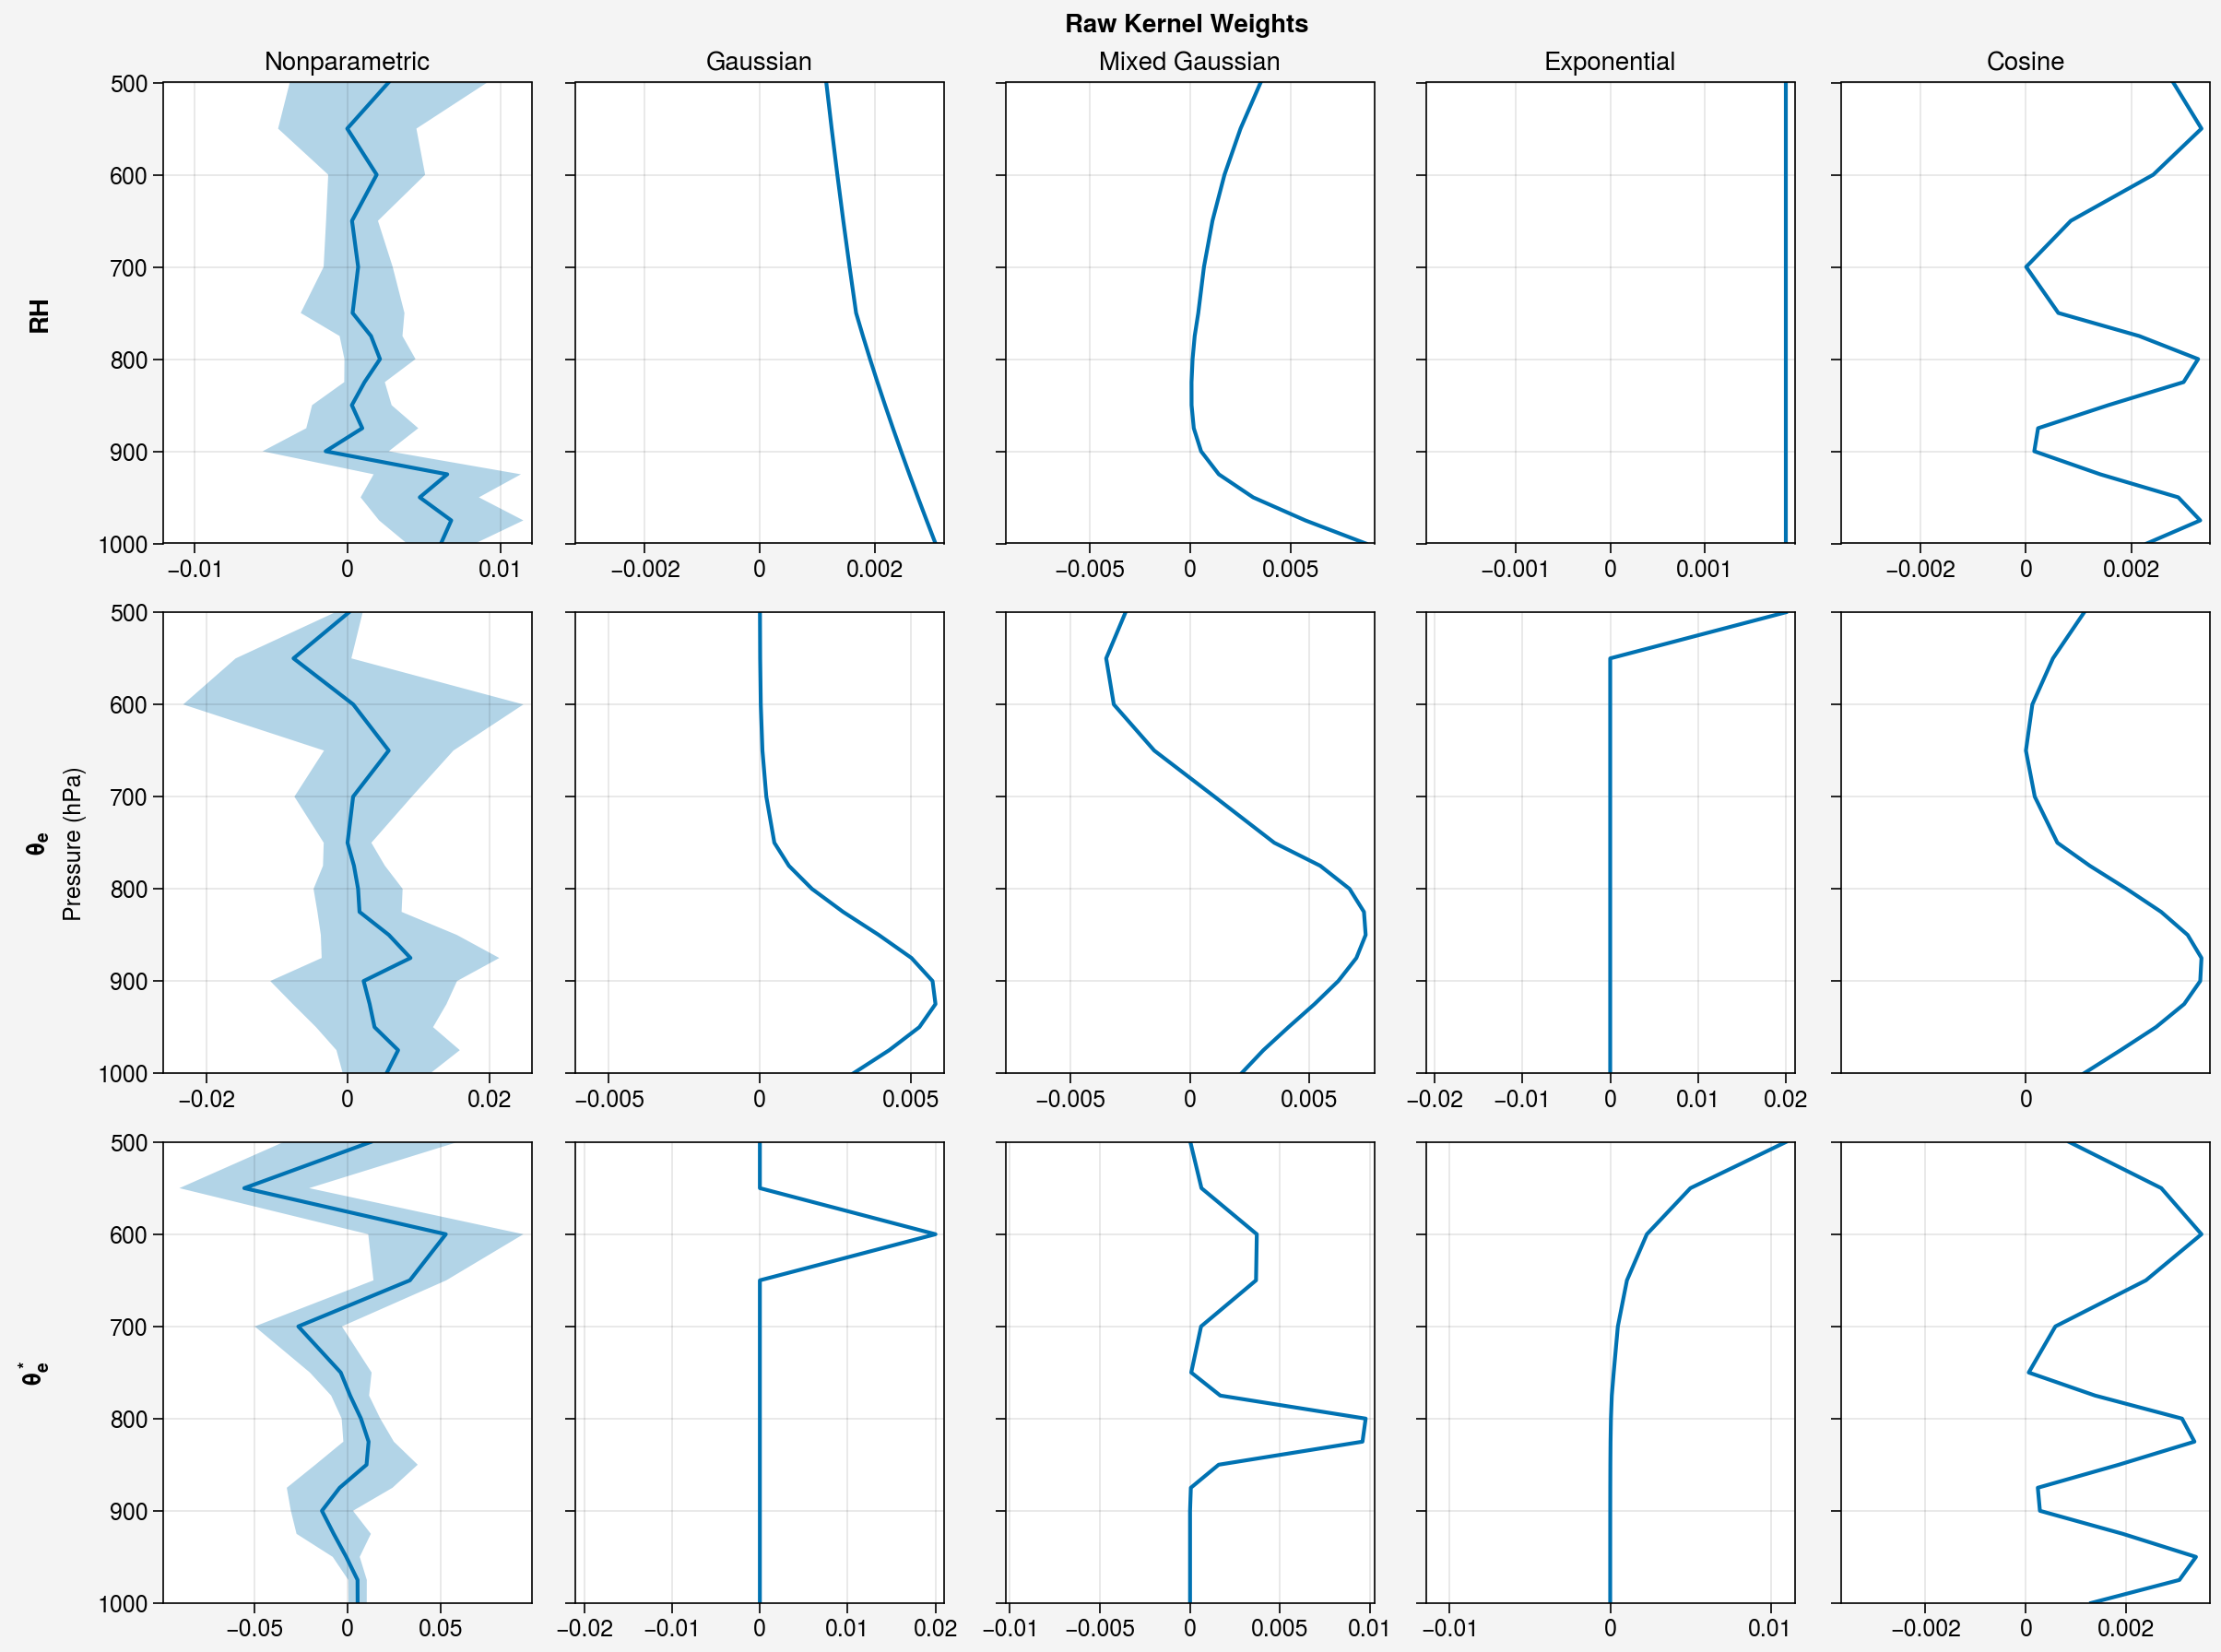

In [66]:
kernelfamilies = [
    ('nonparametric','Nonparametric'),
    ('gaussian','Gaussian'),
    ('mixture','Mixed Gaussian'),
    ('exponential','Exponential'),
    # ('bidirectional','Bidirectional Exponential'),
    ('cosine','Cosine'),
]

family_to_name = {
    family: next((name for name in results if family in name), None)
    for family,_ in kernelfamilies}

def nice_step(xmax):
    # target ~5 ticks from -xmax..xmax (i.e., ~2*xmax span)
    raw = (2 * xmax) / 4  # 4 intervals -> 5 ticks
    if raw == 0 or not np.isfinite(raw):
        return 1.0
    p = 10 ** np.floor(np.log10(raw))
    for m in (1, 2, 5, 10):
        step = m * p
        if step >= raw:
            return step
    return 10 * p

fig,axs = pplt.subplots(nrows=3,ncols=len(kernelfamilies),refwidth=2,refheight=2.5,sharex=False,sharey=True)
axs.format(suptitle='Raw Kernel Weights',
           xlabel='',xticks=0.01,xminorticks='none',
           ylabel='Pressure (hPa)',yminorticks='none',yreverse=True,
           rowlabels=['RH',r'$\theta_e$',r'$\theta_e^*$'])

for j,(family,title) in enumerate(kernelfamilies):
    axs[0,j].format(title=title)
    name = family_to_name[family]
    if name is None:
        continue
    mean = results[name]['mean']
    std  = results[name]['std']
    for i in range(3):
        ax = axs[i,j]
        m = mean.isel(field=i)
        ax.plot(m,lev,linewidth=1.5)
        xmax = float(np.nanmax(np.abs(m.values)))
        if std is not None:
            s = std.isel(field=i)
            ax.fill_betweenx(lev,m-s,m+s,alpha=0.3)
            xmax = max(xmax,float(np.nanmax(np.abs((m-s).values))),float(np.nanmax(np.abs((m+s).values))))
        ax.format(xlim=(-1.05*xmax,1.05*xmax))
        step = nice_step(xmax)
        ticks = np.arange(-np.ceil(xmax/step)*step, np.ceil(xmax/step)*step + 0.5*step, step)
        ax.format(xticks=ticks)

pplt.show()

fig.save('../figs/weights.jpeg',dpi=300)